<a href="https://colab.research.google.com/github/happyendingddd/CRISPR_Cas9_gRNA_design/blob/main/%E2%80%9CCNN_off_target_PR_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras import layers
import sklearn
import matplotlib.pyplot as plt

In [ ]:
after=1

In [ ]:
# 数据导入1
file_path='/content/merge_ot_sgRNA_293r_binary.csv'
data_read=pd.read_csv(file_path,sep=',')
otSeq=np.array(data_read['OT'])
guideSeq=np.array(data_read['Target sgRNA'])
labels=np.array(data_read['Cleavage Frequency'])

In [ ]:
data_read['Target sgRNA'].shape

(536,)

In [ ]:
if after==True:
  # after专属代码
  # 数据导入2（已经是编码形式）
  num_read=guideSeq.shape[0]
  seqdata_gP=np.load('/content/generated_ot_sgRNA_code_293r_positive.npy')[0:num_read-1]
  seqdata_gN=np.load('/content/generated_ot_sgRNA_code_293r_negetive.npy')[0:num_read-1]
  seqdata_g=np.vstack([seqdata_gP,seqdata_gN])
  labels_gP=np.zeros(seqdata_gP.shape[0])+1
  labels_gN=np.zeros(seqdata_gN.shape[0])
  labels_g=np.r_[labels_gP,labels_gN]
  labels_all=np.r_[labels,labels_g]

In [ ]:
# 0ne_hot编码
ntmap = {'A': (1, 0, 0, 0),
         'C': (0, 1, 0, 0),
         'G': (0, 0, 1, 0),
         'T': (0, 0, 0, 1)
         }

def get_seqcode(seq):
    return list(map(lambda c: ntmap[c], seq))

def oneHotcoding(Seq):
    n=0
    for seq in Seq:
        if n==0:
            SeqcodeL=[]
        seqcode=get_seqcode(seq)
        n+=1
        SeqcodeL.append(seqcode)
        seqcode=[]
        SeqcodeA=np.array(SeqcodeL)
    return SeqcodeA

In [ ]:
# OR算子编码sgRNA-DNA
def OR(a,b):
    ab=np.zeros([a.shape[0],a.shape[1]])
    for i in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[i][j] != b[i][j]:
                ab[i][j]=a[i][j]+b[i][j]
            else:
                ab[i][j]=a[i][j]
    return ab

In [ ]:
# 编码
guidecode=oneHotcoding(guideSeq)
otcode=oneHotcoding(otSeq)
guide_ot_code=np.zeros((guidecode.shape[0],guidecode.shape[1],guidecode.shape[2]))
for i in range(len(guidecode)):
    guide_ot_code[i]=OR(guidecode[i],otcode[i])
seqdata=guide_ot_code

In [ ]:
if after==True:
  # after专属代码
  seqdata_all=np.vstack([seqdata,seqdata_g])
  print(seqdata_all.shape)

(1606, 23, 4)


In [ ]:
if after!=True:
  # before专属代码
  seqdata_all=seqdata
  labels_all=labels


In [ ]:
seqdata_all.shape

(1606, 23, 4)

In [ ]:
labels_all.shape

(1606,)

In [ ]:
from sklearn.model_selection import train_test_split
train_seq,test_seq,train_lab,test_lab=train_test_split(seqdata_all,labels_all,train_size = 0.6,random_state=0,stratify=labels_all)

In [ ]:
val_seq=test_seq[:int(test_seq.shape[0]*0.25)];val_lab=test_lab[:int(test_seq.shape[0]*0.25)]
Ntest_seq=test_seq[int(test_seq.shape[0]*0.25)+1:];Ntest_lab=test_lab[int(test_seq.shape[0]*0.25)+1:]

In [ ]:
sum(Ntest_lab)

227.0

In [ ]:
def CNN_model():
  model = tf.keras.Sequential()
  
  model.add(layers.Conv1D(16, 3, padding='same', activation='relu', input_shape=(23,4)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv1D(64, 3,padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(16, activation='relu'))
  #model.add(layers.Dense(2))
  model.add(layers.Dense(2,activation='sigmoid'))

  return model

In [ ]:
model=CNN_model()
#model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_seq, train_lab, epochs=200, batch_size=16,
                    validation_data=(val_seq, val_lab))

Epoch 1/200
61/61 [==============================] - 2s 18ms/step - loss: 0.8662 - accuracy: 0.6001 - val_loss: 0.6763 - val_accuracy: 0.4688
Epoch 2/200
61/61 [==============================] - 1s 8ms/step - loss: 0.4057 - accuracy: 0.8156 - val_loss: 0.6542 - val_accuracy: 0.4812
Epoch 3/200
61/61 [==============================] - 1s 9ms/step - loss: 0.3482 - accuracy: 0.8381 - val_loss: 0.5492 - val_accuracy: 0.7750
Epoch 4/200
61/61 [==============================] - 1s 8ms/step - loss: 0.3600 - accuracy: 0.8178 - val_loss: 0.4965 - val_accuracy: 0.7437
Epoch 5/200
61/61 [==============================] - 1s 9ms/step - loss: 0.2864 - accuracy: 0.8534 - val_loss: 0.3560 - val_accuracy: 0.8062
Epoch 6/200
61/61 [==============================] - 1s 8ms/step - loss: 0.3208 - accuracy: 0.8500 - val_loss: 0.2840 - val_accuracy: 0.8562
Epoch 7/200
61/61 [==============================] - 1s 9ms/step - loss: 0.2268 - accuracy: 0.8910 - val_loss: 0.2381 - val_accuracy: 0.8687
Epoch 8/200


In [ ]:
test_loss, test_acc = model.evaluate(Ntest_seq, Ntest_lab, verbose=2)

16/16 - 0s - loss: 0.7859 - accuracy: 0.8610


In [ ]:
pred_pro=model.predict(Ntest_seq) #计算概率

In [ ]:
pred_pro.shape

(482, 2)

In [ ]:
# PR曲线（精确率/召回率）
from sklearn.metrics import precision_recall_curve,auc
precision, recall, thresholds=precision_recall_curve(Ntest_lab,pred_pro[:,1]) # 计算多种阈值的p,r
pr_auc = auc(recall, precision)
print(pr_auc)

0.9243837719890594


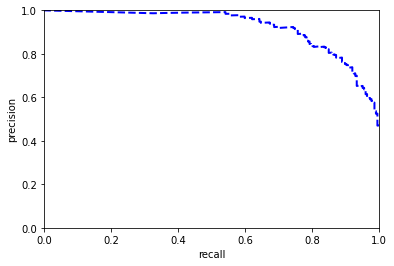

In [ ]:
# PR曲线
def plot_pr_curve(recall,precision,label=None):
    plt.plot(recall,precision,'b--',linewidth=2,label=label)
    plt.axis([0,1,0,1])
    plt.xlabel('recall')
    plt.ylabel('precision')
plot_pr_curve(recall,precision)
plt.show()

In [ ]:
listnew=[list(recall),list(precision)]

In [ ]:
#def savedata2D(list1,filepath,test_acc,AUC):
def savedata2D(list1,filepath):
    output = open(filepath,'w+',encoding='utf-8')
    for i in range(len(list1)):
        for j in range(len(list1[i])):
                output.write(str(list1[i][j]))    
                output.write('\t')   
        output.write('\n')
    #output.write(AUC)
    #output.write('\n')
    #output.write(str(test_acc))
    #output.write('\n')
    output.close()

In [ ]:
if after==True:
  fp_pr='/content/data_PR_off_after.txt'
else:
  fp_pr='/content/data_PR_off_before.txt'
savedata2D(listnew,fp_pr)